# Practicum 6: Supply II - Transmission and Leakage

We talked today about environmental regulation in electricity markets.

We will learn today how to build a model of an electricity market with incomplete regulation ("leakage").

The data and code are based on the paper "Border Carbon Adjustments When Carbon Intensity Varies Across Producers: Evidence from California," by Meredith Fowlie, Claire Petersen, and Mar Reguant.

We first load relevant libraries and set the path.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyomo.environ import *

In [4]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day6/practicum/"

## Data

The data have been generated by compiling several publicly-available sources about the market outcomes of the Western interconnection areas. This is a recent dataset (2019 data) benefiting from better availability of data on wind and solar production available at EIA. 

Most of the data are region-hourly, and data on power plants is plant-region.

Here I provide a description of the variables (available in the online appendix as well).

* a: Electricity demanded when price is zero.
* b: Slope of electricity demand curve.
* qmr: Quantity of electricity from wind, solar, nuclear, and hydroelectric energy sources, which “must run” in the model for each region
* mc: Marginal cost of electricity production.
* er: Emissions rate.
* mw: Capacity.
* cf: Capacity factor.
* flag: Dummy variable flagging natural gas units near large cities to mandate a minimum required generation.
* isca: Dummy variable indicating the generating unit is in California.
* istax: Dummy variable indicating the generating unit is in California’s tax jurisdiction.
* lines: Maximum capacity that can flow through transmission lines.
* fct: Distribution of electricity flow originating in a region along the transmission lines.
* w: Weight.

The files are stored as .CSV matrices, ready to be imported and used in the model. These CSV files were generated by preparation code from raw sources and are subject to assumptions, e.g., for the marginal cost of the power plants and clustering techniques to simplify the regions and the number of observations.

In [6]:
# we load a bunch of matrices that were created via other datasets
datasets = [
    "a", "b", "cf", "er", "fct", "flag", "fuel",
    "isca", "ischp", "istax", "lines",
    "mc", "mw", "qmr", "qrw", "w",
]

# we put them into data
data: dict[str, np.ndarray] = {}

for x in datasets:
    fp = f"{dirpath}/data_leakage/{x}.csv"
    # Tables.matrix -> plain numeric matrix -> NumPy array
    data[x] = pd.read_csv(fp, header=None).to_numpy()

In [7]:
data["fct"]  # intercept of demand for 4 regions and 100 periods

array([[ 0.623,  0.378, -0.144,  0.144,  0.234],
       [ 0.378,  0.623,  0.144, -0.144, -0.234],
       [ 0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.   ]])

In [8]:
data["mc"] # Marginal cost of each plant providing electricity to each of the 4 regions

array([[  16.15117325,   22.31617524,   22.7296968 ,   22.73074339,
          22.82374802,   22.91634678,   22.97061353,   22.97453173,
          23.0079581 ,   23.02678525,   23.13070398,   23.43634663,
          23.56961365,   23.6526121 ,   23.87693009,   24.00937361,
          24.01882801,   24.03363177,   24.1095735 ,   24.11562137,
          24.15722146,   24.41387635,   24.51556359,   24.58585167,
          24.66614273,   24.67582818,   24.687864  ,   24.70740505,
          24.7325506 ,   24.80728999,   24.8207329 ,   24.9364362 ,
          25.10556848,   25.12608764,   25.2596878 ,   25.46610658,
          25.50202393,   25.54849794,   25.77226059,   25.94099917,
          25.94322601,   26.06863257,   26.17648324,   26.22947051,
          26.23496321,   26.35309098,   26.56266178,   26.58667074,
          26.71452332,   26.73546882,   26.85859772,   27.23473291,
          27.33015747,   27.3652374 ,   27.42038121,   28.05784257,
          28.26701542,   28.28451355,   28.50866

In [9]:
data["istax"]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       

**Note:** We can explore how the network is specified. We have 5 lines: (4 to 2 and 3, 2 and 3 to 1 and 2 to 3) with a maximum capacity.

With that, every unit of electricity produced in each of the 4 regions will flow across regions according to flow factors `fct` (taking CA as reference)  


In [ ]:
# The amount of transmission available between states
data["lines"]

array([[6.85  ],
       [7.13  ],
       [0.895 ],
       [1.1075],
       [1.145 ]])

In [ ]:
# How power from each of the other regions gets to California (which path it takes)
data["fct"]

array([[ 0.623,  0.378, -0.144,  0.144,  0.234],
       [ 0.378,  0.623,  0.144, -0.144, -0.234],
       [ 0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.   ]])

## Model

We will be solving the model using the "maximization" approach of optimizing economic surprlus. This will save us from coding up the transmission lines constraints using mixed integer programming. 

The same "maximization" approach is used in the paper "Strategic Policy Choice in State-Level Regulation: The EPA's Clean Power Plan." by Bushnell, James B., Stephen P. Holland, Jonathan E. Hughes, and Christopher R. Knittel. We build on this model, which is available in AMPL at [http://doi.org/10.3886/E114648V1](http://doi.org/10.3886/E114648V1).

In comparison, one big limitation of our short conference paper is that it does not include investment.


The model follows similar steps from last week:

1. Declare the model to initialize it. We also call it "model" here, but it could be any name.

2. Declare some useful indices to keep track of regions, plants, and lines. [Note: There is no time here because the function will only solve one hour at a time]

3. Declare variables.

4. Declare objective function.

5. Declare constraints, [New] including the transmission lines.


### Adding transimission and carbon taxes

We will start by considering the case where all electricity producers are regulated under the same carbon pricing regime.


In [ ]:
def clear_market_at_t_simple(d: dict, t: int = 1, tax: float = 17.0):
    """
    Pyomo translation of the JuMP/Ipopt model for leakage
    """

    # --- dimensions ---
    R = d["a"].shape[0]          # number of regions
    U = d["mc"].shape[1]         # number of plants
    L = d["lines"].shape[0]      # number of lines

    # p0 = a ./ b (intercept of inverse demand)
    p0 = d["a"] / d["b"]

    # --- model ---
    m = ConcreteModel()

    # Sets
    m.R = RangeSet(0, R - 1)
    m.Rother = RangeSet(1, R - 1)
    m.U = RangeSet(0, U - 1)
    m.Z = RangeSet(0, R - 2)   # yflow
    m.L = RangeSet(0, L - 1)

    # Decision variables
    m.price = Var(m.R)                 # unrestricted
    m.demand = Var(m.R)                # unrestricted
    m.yflow = Var(m.Z)                 # unrestricted
    m.q = Var(m.R, m.U, domain=NonNegativeReals)

    # Summary variables
    m.surplus = Var()
    m.totalcost = Var()
    m.totalecost = Var()
    m.totale = Var(m.R)

    # Objective: Max surplus - totalcost - totalecost
    m.obj = Objective(expr=m.surplus - m.totalcost - m.totalecost, sense=maximize)

    # --- constraints ---
    # Surplus
    m.surplus_def = Constraint(
        expr=m.surplus
        == sum(0.5 * (p0[r, t] + m.price[r]) * m.demand[r] for r in m.R)
    )

    # Fuel cost
    m.totalcost_def = Constraint(
        expr=m.totalcost
        == sum(m.q[r, i] * d["mc"][r, i] for r in m.R for i in m.U)
    )

    # Emissions tax cost (all of them here)
    m.totalecost_def = Constraint(
        expr=m.totalecost
        == sum(m.q[r, i] * d["er"][r, i] * tax for r in m.R for i in m.U)
    )

    # Total emissions by region
    m.totale_def = Constraint(m.R,
        rule=lambda m, r: m.totale[r] == sum(m.q[r, i] * d["er"][r, i] for i in m.U),
    )

    # Demand system
    m.demand_def = Constraint(m.R,
        rule=lambda m, r: m.demand[r] == d["a"][r, t] - d["b"][r, t] * m.price[r],
    )

    # Capacity upper bound
    m.cap_ub = Constraint(m.R,m.U,
        rule=lambda m, r, i: m.q[r, i] <= 0.95 * d["mw"][r, i] / 1000.0,
    )

    # Minimum generation
    m.min_gen = Constraint(m.R, m.U,
        rule=lambda m, r, i: m.q[r, i] >= d["cf"][r, i] * d["flag"][r, i] * d["mw"][r, i] / 1000.0,
    )
    # Market clearing:
    # CA = region 0 (swing node)
    m.mkt_clear_CA = Constraint(
        expr=(
            m.demand[0]
            == sum(m.q[0, i] for i in m.U)
            + d["qmr"][0, t]
            + sum(m.yflow[z] for z in m.Z)
        )
    )
    # Other regions
    m.mkt_clear_other = Constraint(m.Rother, rule= lambda m, r: 
        m.demand[r] + m.yflow[r - 1] == sum(m.q[r, i] for i in m.U) + d["qmr"][r, t])

    # Transmission constraints for each line l:
    # -lines[l] <= sum(fct[z,l] * yflow[z]) <= lines[l]
    m.line_ub = Constraint(m.L, rule=lambda m, l: 
            sum(d["fct"][z, l] * m.yflow[z] for z in m.Z) <= d["lines"][l])
    m.line_lb = Constraint(m.L, rule=lambda m, l: 
            sum(d["fct"][z, l] * m.yflow[z] for z in m.Z) >= -d["lines"][l])

    # --- solve ---
    solver = SolverFactory("ipopt")
    # JuMP used print_level=0; in Pyomo/Ipopt:
    solver.options["print_level"] = 0

    res = solver.solve(m, tee=False)

    # Map solver status to something close to JuMP's strings
    ok = (res.solver.termination_condition in (
        TerminationCondition.optimal,
        TerminationCondition.locallyOptimal,
    ))

    status = str(res.solver.termination_condition)

    if ok:
        # Helper to extract values into numpy arrays matching Julia shapes
        price = np.array([value(m.price[r]) for r in m.R])
        demand = np.array([value(m.demand[r]) for r in m.R])
        yflow = np.array([value(m.yflow[z]) for z in m.Z])  # length R-1

        q = np.empty((R, U), dtype=float)
        for r in m.R:
            for i in m.U:
                q[r - 1, i - 1] = value(m.q[r, i])

        totale = np.array([value(m.totale[r]) for r in m.R])

        return {
            "status": status,
            "surplus": value(m.surplus),
            "totalcost": value(m.totalcost),
            "totalecost": value(m.totalecost),
            "totale": totale,
            "price": price,
            "demand": demand,
            "yflow": yflow,
            "q": q,
        }
    else:
        return {"status": status}

In [82]:
results_t= clear_market_at_t_simple(data, tax=20.0)

In [83]:
print(results_t["price"])

[39.33275489 44.77014451 33.89536527 39.83019528]


### Adding leakage regulation and reshuffling 

In the paper, the model considers several cases.

1. No regulation, tax is 0.
2. Uniform tax, every region (it corresponds to the case discussed above).
3. CA tax only.
4. Tax of imports at default rate, with opt-out.
5. Tax of imports at default rate, no opt-out.

I don't put it here to keep the code simple (but there is code available).

### Creating a function that will run the market for many days

We create a `clear_market_loop` function that will run several days and store the results.


In [84]:
def clear_market_loop(d: dict, T: int = 100, case: int = 2, tax: float = 17.0, default: float = 0.428):
    """
    This will solve the model for several time periods.
    """

    # prepare buckets
    out = {
        "status": [],
        "surplus": [],
        "totalcost": [],
        "totalecost": [],
        "totale": [],
        "price": [],
        "demand": [],
        "yflow": [],
        "q": [],
        "w": [],
    }

    T_eff = min(T, d["a"].shape[1])

    for t in range(T_eff): 
        res = clear_market_at_t_simple(d, t=t)

        if res.get("status") in (TerminationCondition.optimal,TerminationCondition.locallyOptimal):
            out["status"].append(res["status"])
            out["surplus"].append(res["surplus"])
            out["totalcost"].append(res["totalcost"])
            out["totalecost"].append(res["totalecost"])
            out["totale"].append(res["totale"])
            out["price"].append(res["price"])
            out["demand"].append(res["demand"])
            out["yflow"].append(res["yflow"])
            out["q"].append(res["q"])
            out["w"].append(d["w"][t] if isinstance(d["w"], np.ndarray) else d["w"][t])
        else:
            # Julia returns a formatted string and exits early
            return f"Hour {t} failed with status {res.get('status')}!"

    return out


In [85]:
results = clear_market_loop(data, T=100)

In [86]:
# we have one row for each time period
results["demand"]

[array([29.71044016, 29.63156696, 10.72435992,  7.42694356]),
 array([26.60316977, 25.16055209, 11.67419414,  6.54571353]),
 array([33.10376056, 37.64038997, 12.73373765,  9.41520501]),
 array([25.22788965, 27.59722022,  9.62731533,  7.10018038]),
 array([24.08862618, 25.84262154,  9.14497462,  6.59557999]),
 array([33.40468933, 33.38521896, 19.10005802,  9.6230445 ]),
 array([40.49276267, 44.73444088, 17.040831  , 11.66128075]),
 array([44.21046305, 36.77863528, 19.46094418,  9.44177773]),
 array([28.83361173, 27.97439009, 11.83433336,  7.24411092]),
 array([22.26433628, 24.83697301,  8.60106622,  6.65830277]),
 array([29.94148021, 31.98998084, 11.52852658,  8.14703729]),
 array([37.0993582 , 34.96940029, 14.69341226,  9.2363962 ]),
 array([22.18397982, 29.20655316,  8.68302956,  7.29779988]),
 array([29.84436816, 33.94171002, 10.08313852,  8.11330872]),
 array([30.712505  , 43.16735676, 12.17266934, 10.15395273]),
 array([25.7725526 , 29.67270826, 10.22085783,  7.56294288]),
 array([

A note on the structure of the data as these things can be very **specific** (different shapes for each object).

We can convert the variables to data frames so that we can handle them more easily.

In [98]:
# Example to get a price dataset
df_price = pd.DataFrame(results["price"])
df_price = df_price.rename(columns={0: "price_CA", 1: "price_NW", 2: "price_SW", 3: "price_RK"})
df_price["weights"] = np.array(results["w"])

In [99]:
df_price

,price_CA,price_NW,price_SW,price_RK,weights
0,38.076269,42.946488,33.206050,40.069689,0.006987
1,37.795176,42.541251,33.049102,38.436876,0.013286
2,39.070479,44.829802,33.311156,44.107720,0.017409
3,35.922071,41.204206,30.639936,40.069689,0.008476
4,38.228718,42.946488,33.510948,38.436876,0.015233
...,...,...,...,...,...
95,58.847889,73.877003,43.818776,48.780116,0.002176
96,38.568691,44.088280,33.049102,39.962597,0.008705
97,38.659008,44.829802,32.488215,41.418301,0.010881
98,38.574785,42.532981,34.616588,40.290146,0.008017


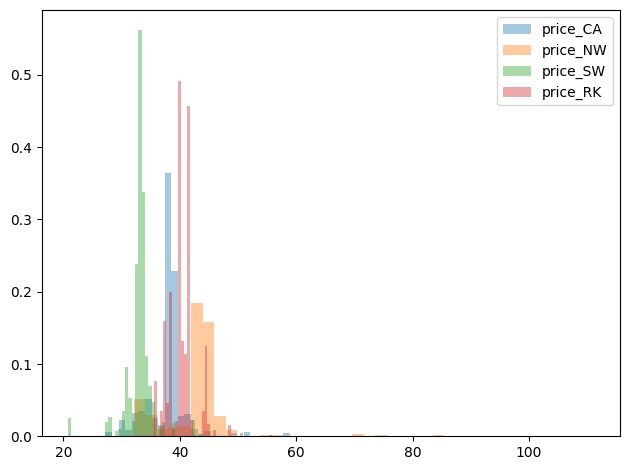

In [100]:
# histogram of the four regions in the price dataframe
plt.figure()
for col in ["price_CA", "price_NW", "price_SW", "price_RK"]:
    plt.hist(df_price[col],
             weights=df_price["weights"], 
             bins=40, alpha=0.4, density=True, 
             label=str(col))

plt.legend()
plt.tight_layout()
plt.show()

## Follow-up exercises

1. Modify the output code in the market loop so that it is just one row per time period, making it easier to save as a dataframe directly.

2. Try different taxes on emissions to see how they impact the results. Also try to compare taxing only California to taxing all states. 

3. Could you do a Hausman-style (2025) calculation? What are the benefits of removing all transmission constraints according to this model?
